<a href="https://colab.research.google.com/github/mattderri/CMP/blob/main/Capacitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importo le librerie necessarie
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as random
from scipy.optimize import curve_fit

In [ ]:
#Leggo il file di output generato in precedenza
data_true='/content/true.dat'
data=pd.read_csv(data_true,sep='\t')

In [ ]:
c1=data["C1"].values
ceq=data["C_eq"].values

In [ ]:
np.random.seed(314)

In [ ]:
#Genero ed assegno un offset a C1 e C_eq
c1_offset=[c1[i]+random.gauss(0,0.5) for i in range(len(c1))]
ceq_offset=[ceq[i]+random.gauss(0,0.5) for i in range(len(ceq))]

In [ ]:
#Stampo i valori sul file offset.dat
file=open('offset.dat','w')
for i in range(len(c1_offset)):
  file.write("%.2f\t" %c1_offset[i])
  file.write("%.2f\n" %ceq_offset[i])
file.close()

$C_{eq_1}=C_1+C_2=C_1+10 \text{pF} \\ 
C_{eq_2}=C_3+C_4=20 \text{pF} \\
C_{eq}=\frac{(C_1+10)20}{C_1+10+20}=\frac{20(C_1+10)}{C_1+30}=\frac{C_1+10}{C_1/20+30/20}=\frac{C_1+10}{0.05*C_1+1.5} \\
f(x)=\frac{1}{\frac{1}{x+a}+b}=\frac{x+a}{1+xb+ab}$

Mi aspetto quindi di avere $a\simeq10$ e $b\simeq0.05$

In [ ]:
#Definisco f(x) ed eseguo il fit
def f(x,a,b):
  return 1/(1/(x+a)+b)
  
popt,pcov=curve_fit(f,c1_offset,ceq_offset)
popt

array([10.19110695,  0.05012498])

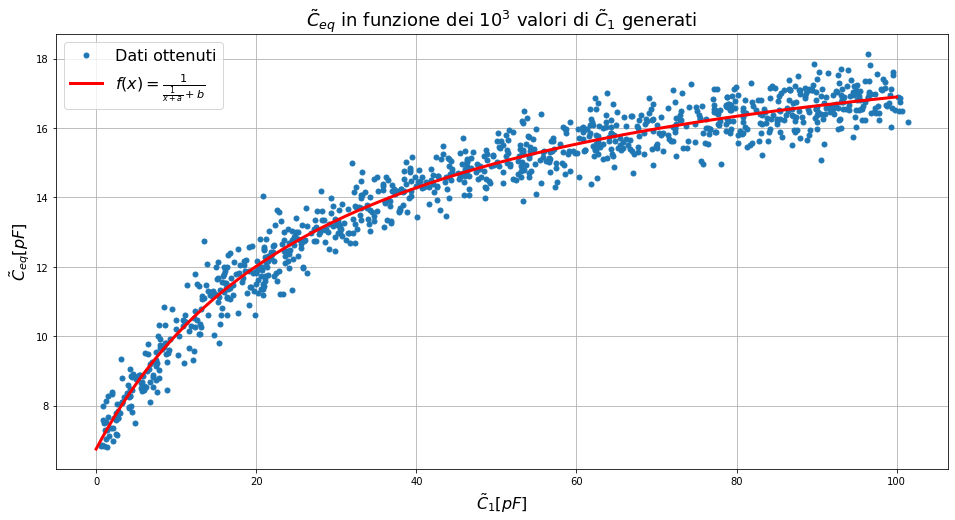

In [ ]:
#Plotto i risultati
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(c1_offset,ceq_offset,'o',markersize=5,label='Dati ottenuti')
xdata=np.linspace(0,100,1000)
plt.plot(xdata,f(xdata,*popt),'-',color='red',label=r'$f(x)=\frac{1}{\frac{1}{x+a}+b}$',linewidth=3)
plt.title(r'$\tilde{C}_{eq}$' ' in funzione dei ' r'$10^3$' ' valori di ' r'$\tilde{C}_1$' ' generati',fontsize=18)
plt.xlabel(r'$\tilde{C}_1 [pF]$',fontsize=16)
plt.ylabel(r'$\tilde{C}_{eq} [pF]$',fontsize=16)
plt.legend(loc=2, prop={'size': 16})
plt.savefig("CeqC1.pdf")

In [ ]:
#Genero un errore da associare a C_eq
delta_ceq=np.array([random.gauss(0,3) for i in range(len(ceq))])

In [ ]:
#Stampo i valori sul file errorbar.dat
file=open('errorbar.dat','w')
for i in range(len(delta_ceq)):
  file.write("%.2f\n" %delta_ceq[i])
file.close()

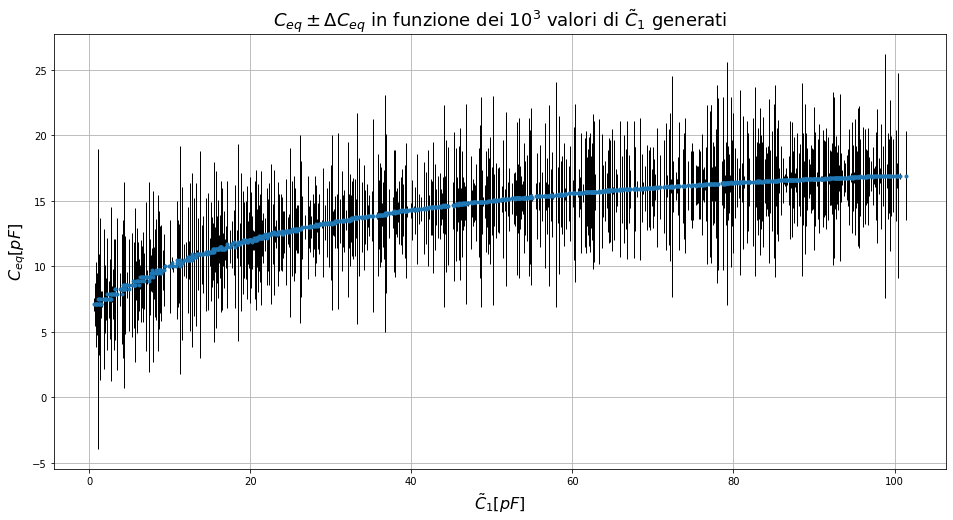

In [ ]:
#Plotto i risultati
plt.figure(figsize=(16,8))
plt.grid()
plt.errorbar(c1_offset,ceq,yerr=delta_ceq,fmt="o",markersize=3,ecolor='black',linewidth=1)
plt.title(r'$C_{eq}\pm\Delta C_{eq}$' ' in funzione dei ' r'$10^3$' ' valori di ' r'$\tilde{C}_1$' ' generati',fontsize=18)
plt.xlabel(r'$\tilde{C}_1 [pF]$',fontsize=16)
plt.ylabel(r'$C_{eq} [pF]$',fontsize=16)
plt.savefig("Ceq+delta.pdf")

#MonteCarlo



### EMCEE

In [ ]:
!pip install emcee

In [ ]:
!pip install corner

In [ ]:
import emcee
import corner

$$\ln \mathcal{L}(\mathbf{d}|\boldsymbol{\theta}) = \ln p(\mathbf{x}, \mathbf{y}, \boldsymbol{s}| a,b) = -{1\over 2}\sum_k\left[ {{[y_k - f(x_k,a,b)]^2}\over {s_k^2}} + \ln (2\pi s_k^2)\right]\\
s_k^2=\sigma_k^2\\
f(x,a,b)=\frac{x+a}{1+ab+xb}$$

In [ ]:
a_true=10
b_true=0.05

In [ ]:
def log_likelihood(theta,x,y,yerr):
    a,b=theta
    model=1/(1/(x+a)+b) 
    sigma2=np.power(yerr,2)
    return -0.5*np.sum(((y-model)**2/sigma2)+np.log(2*np.pi*sigma2))

False
Desired error not necessarily achieved due to precision loss.
a = 10.0217 (True: 10.0000)
b = 0.0500 (True: 0.0500)


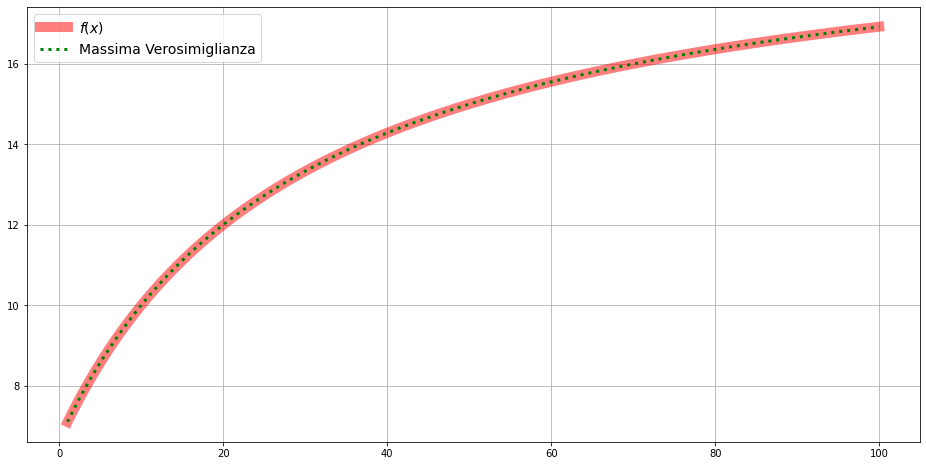

In [ ]:
from scipy.optimize import minimize

nll=lambda *args:-log_likelihood(*args)
initial=np.array([a_true,b_true])  

soln=minimize(nll,initial,args=(c1_offset,ceq,delta_ceq))
print(soln.success)
print(soln.message)

a_ml,b_ml=soln.x
print("a = {0:.4f} (True: {1:.4f})".format(a_ml, a_true))
print("b = {0:.4f} (True: {1:.4f})".format(b_ml, b_true))

plt.figure(figsize=(16,8))
plt.grid()

x=np.linspace(1,100,1000)
plt.plot(x,1/(1/(x+a_true)+b_true),"k",alpha=0.5,lw=10,color='red',label=r'$f(x)$')

plt.plot(x,1/(1/(x+a_ml)+b_ml), ":k", lw=3,color='green',label="Massima Verosimiglianza")
plt.legend(fontsize=14)

In [ ]:
#Definisco le prior per a e b come uniformi in  un certo intervallo centrato attorno al valore vero
def log_prior(theta):
  a,b=theta
  if 5 < a < 15 and 0.01 < b < 0.1:
        return 0.0
  return np.inf

In [ ]:
def log_probability(theta,x,y,yerr):
    lp=log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(theta,x,y,yerr)

In [ ]:
nwalkers=32
ndim=2
nmcmc=5000
pos=soln.x+1e-4*np.random.randn(nwalkers,ndim)

sampler=emcee.EnsembleSampler(nwalkers,ndim,log_probability,args=(c1_offset,ceq,delta_ceq))
sampler.run_mcmc(pos,nmcmc,progress=True); 

100%|██████████| 5000/5000 [00:50<00:00, 98.43it/s] 


Text(0.5, 0, 'MCMC step')

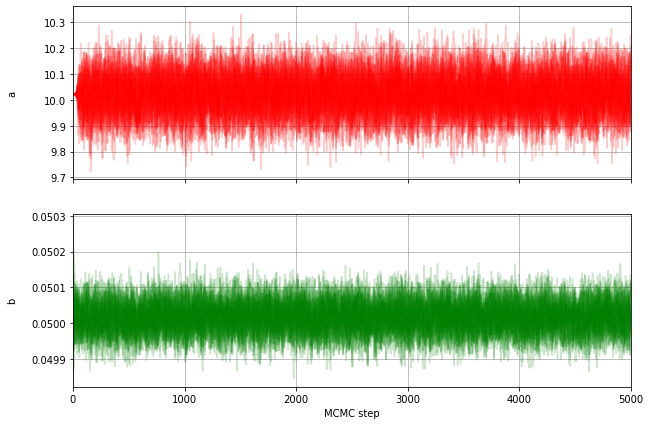

In [ ]:
fig,axes=plt.subplots(2,figsize=(10,7),sharex=True)
samples=sampler.get_chain()
labels=["a","b"]
col=['r','g']
for i in range(ndim):
    ax=axes[i]
    ax.grid(True)
    ax.plot(samples[:, :, i],col[i],alpha=0.2)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)

axes[-1].set_xlabel("MCMC step")

In [ ]:
tau=sampler.get_autocorr_time()
print(tau)

[32.79508691 31.54597047]


In [ ]:
flat_samples=sampler.get_chain(discard=100,thin=15,flat=True)
print(flat_samples.shape)

(10432, 2)


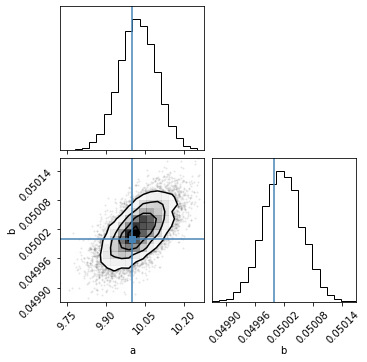

In [ ]:
fig=corner.corner(flat_samples,labels=labels,truths=[a_true,b_true])

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc=np.percentile(flat_samples[:, i],[5, 50, 95])
    interval=np.diff(mcmc)
    txt="\mathrm{{{3}}}={0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt=txt.format(mcmc[1], interval[0], interval[1], labels[i])
    display(Math(txt))

print("Valori veri:")
print("a={0:.5f}".format(a_true))
print("b={0:.5f}\n".format(b_true))

print("Stima con la massima verosimiglianza:")
print("a={0:.5f}".format(a_ml))
print("b={0:.5f}\n".format(b_ml))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Valori veri:
a=10.00000
b=0.05000

Stima con la massima verosimiglianza:
a=10.02170
b=0.05002



###PYMC

In [ ]:
!pip install pymc

In [ ]:
import pymc

In [ ]:
a=pymc.Uniform('a',5,15,value=soln.x[0])
b=pymc.Uniform('b',0.01,0.1,value=soln.x[1])

In [ ]:
@pymc.deterministic
def model(a=a,b=b,x=c1_offset):
    return 1/(1/(x+a)+b)

In [ ]:
@pymc.deterministic
def tau(yerr=delta_ceq,model=model):
    return np.power(yerr**2,-1)

In [ ]:
data=pymc.Normal('data',mu=model,tau=tau,value=ceq,observed=True)

In [ ]:
nsampler=20000
sampler=pymc.MCMC([a,b,model,delta_ceq,ceq,c1_offset])
sampler.sample(iter=nsampler)

 [-----------------100%-----------------] 20000 of 20000 complete in 17.7 sec

In [ ]:
a.summary()
b.summary()


a:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	10.023           0.07             0.003            [ 9.897 10.174]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	9.891            9.974           10.022         10.067        10.171
	

b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.05             0.0              0.0                  [0.05 0.05]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.05             0.05            0.05           0.05          0.05
	


Plotting b
Plotting a


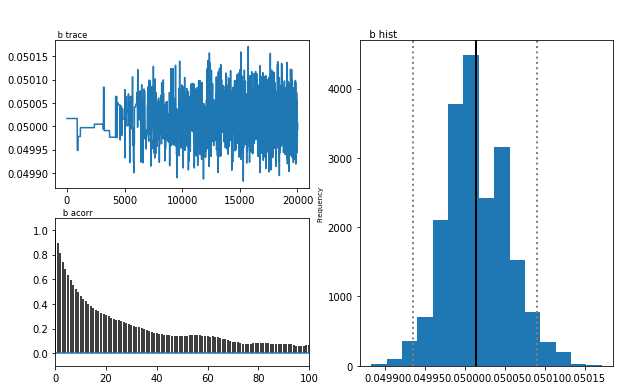

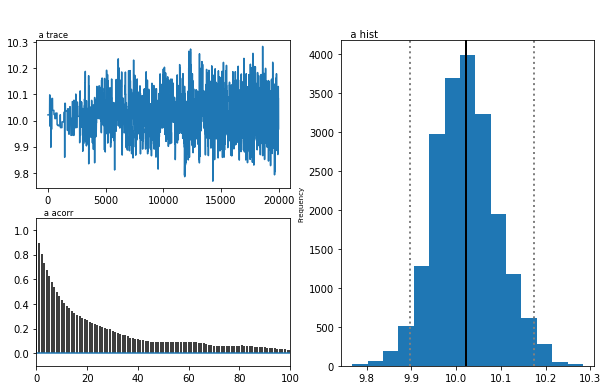

In [ ]:
pymc.Matplot.plot(sampler)

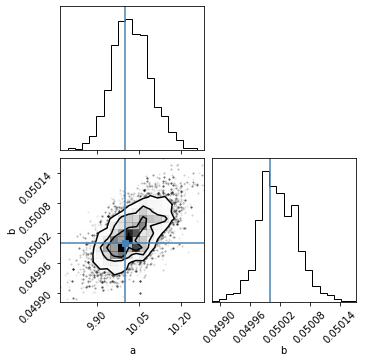

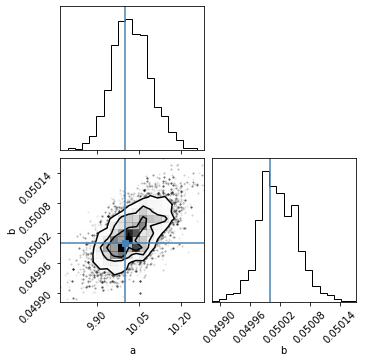

In [ ]:
samples=np.array([a.trace(),b.trace()]).T
corner.corner(samples[:,:],labels=['a','b'], 
              truths=[a_true,b_true])